In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/MyDrive/Guitars
%ls

/gdrive/MyDrive/Guitars
Test/  Train/  Val/


In [ ]:
# Librerie

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.11.0


In [ ]:
# Random seed

seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Datasets (Training e Validation)

training_dir = 'Train'
validation_dir = 'Val'

train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
valid_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(128,128),
                                                           color_mode='rgb',
                                                           classes=["flying", "les paul", "sg", "stratocaster", "telecaster"],
                                                           class_mode='categorical',
                                                           batch_size=8,
                                                           shuffle=True,
                                                           seed=seed)
                                                           
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(128,128),
                                               color_mode='rgb',
                                               classes=["flying", "les paul", "sg", "stratocaster", "telecaster"],
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 1530 images belonging to 5 classes.
Found 199 images belonging to 5 classes.


In [ ]:
# Dizionario che associa i numeri ai nomi delle classi (modelli chitarra)
class_dict = {v: k for k, v in train_gen.class_indices.items()}

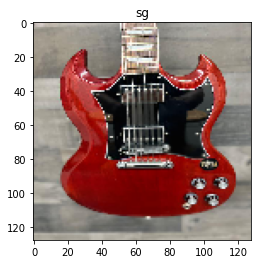

In [ ]:
# Immagine esempio training set

images, labels = next(train_gen)

for i in range(1):
    plt.imshow(images[i])
    plt.title(class_dict[labels[i].argmax()])
    plt.show()

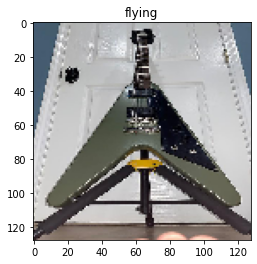

In [ ]:
# Immagine esempio validation set

images, labels = next(valid_gen)

for i in range(1):
    plt.imshow(images[i])
    plt.title(class_dict[labels[i].argmax()])
    plt.show()

In [ ]:
# Parametri modello e training
input_shape = (128, 128, 3)
epochs = 1000

In [ ]:
# Funzione di costruzione del modello

def build_model(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    
    pool3 = tfkl.MaxPooling2D()(conv3)

    global_average_pool = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(pool3)
    dropout = tfkl.Dropout(0.3, seed=seed)(global_average_pool)
    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer= tfk.regularizers.L1L2(l1=1e-5, l2=1e-4), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=5, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer= tfk.regularizers.L1L2(l1=1e-5, l2=1e-4), name='output_layer')(dropout)

    # Connessione input-output
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model1')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    
    return model

In [ ]:
model = build_model(input_shape)
model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496

In [ ]:
# Training del modello
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True)]
).history

Epoch 1/1000
192/192 [==============================] - 330s 2s/step - loss: 1.6937 - accuracy: 0.2137 - val_loss: 1.6390 - val_accuracy: 0.2312
Epoch 2/1000
192/192 [==============================] - 18s 93ms/step - loss: 1.6398 - accuracy: 0.2288 - val_loss: 1.6247 - val_accuracy: 0.2412
Epoch 3/1000
192/192 [==============================] - 17s 89ms/step - loss: 1.6235 - accuracy: 0.2562 - val_loss: 1.6084 - val_accuracy: 0.2714
Epoch 4/1000
192/192 [==============================] - 17s 89ms/step - loss: 1.6104 - accuracy: 0.2693 - val_loss: 1.5856 - val_accuracy: 0.3015
Epoch 5/1000
192/192 [==============================] - 18s 96ms/step - loss: 1.5863 - accuracy: 0.2869 - val_loss: 1.5769 - val_accuracy: 0.3266
Epoch 6/1000
192/192 [==============================] - 17s 90ms/step - loss: 1.5728 - accuracy: 0.3183 - val_loss: 1.5533 - val_accuracy: 0.3317
Epoch 7/1000
192/192 [==============================] - 17s 90ms/step - loss: 1.5416 - accuracy: 0.3275 - val_loss: 1.5344 - 

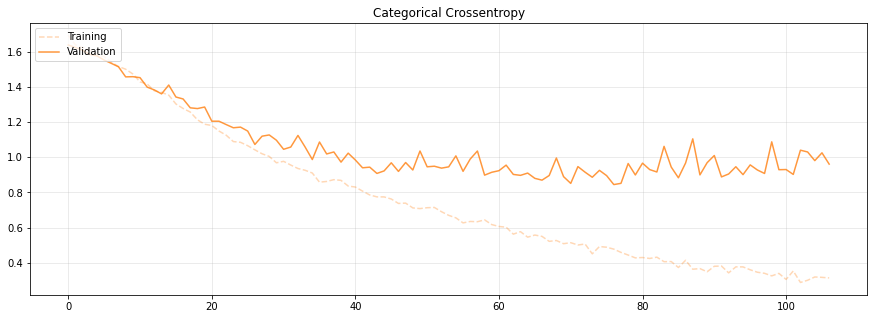

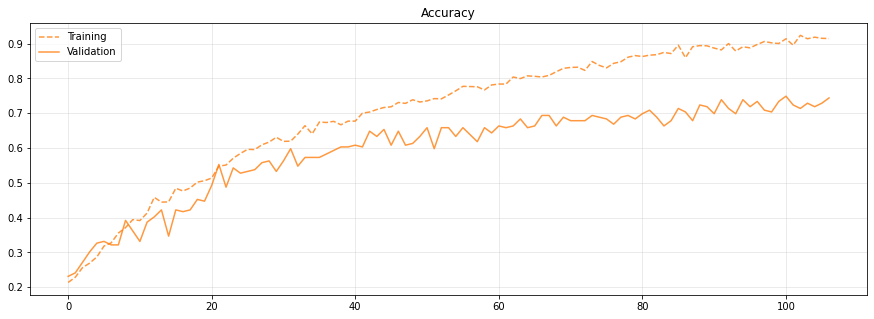

In [ ]:
# Training info
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Test set

test_dir = "Test"

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

test_ds = train_data_gen.flow_from_directory(directory=test_dir,
                target_size=(128,128),
                color_mode='rgb',
                classes=["flying", "les paul", "sg", "stratocaster", "telecaster"],
                class_mode='categorical',
                batch_size=8,
                shuffle=True,
                seed=seed)

# Valutazione delle performance sul test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test set accuracy: {test_acc}")

Found 100 images belonging to 5 classes.
13/13 [==============================] - 26s 2s/step - loss: 0.7288 - accuracy: 0.7500
Test set accuracy: 0.75


1/1 [==============================] - 0s 21ms/step


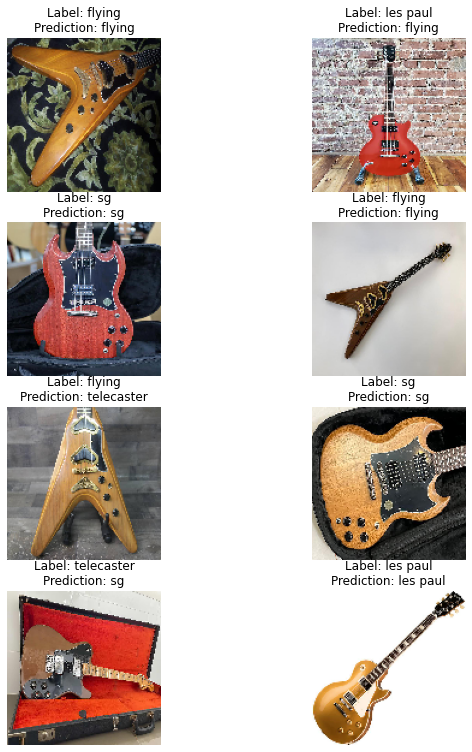

In [ ]:
# Prova di riconoscimento sul test set

preds = model.predict(test_ds)

x_test, y_test = next(test_ds)

preds = model.predict(x_test)

fig, axs = plt.subplots(4, 2, figsize=(10, 13))
axs = axs.flatten()

for img, label, pred, ax in zip(x_test[:16], y_test[:16], preds[:16], axs):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Label: {}\nPrediction: {}".format(class_dict[np.argmax(label)], class_dict[np.argmax(pred)]))
    
plt.show()